# Visualization of Word Embeddings Quality

**Outline**

1. Read the top word embedding only
2. Plot epoch_losses, train_accuracies, train_mses, test_accuracies, test_mses
3. Using the best model, test aginst 2 pairs of analogous words
    * plot t-sne
    * plot PCA
4. Pass 2 target words through 1 forward pass of the skip-gram model and evaluate ability to find context words given a target word.

In [1]:
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# import libraries relevant to plotting (t-SNE)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#### Define all the functions

In [2]:
# define cosine similarity scores between 2 word vectors
def similarity_score(target_word_embedding, context_word_embedding):
    return np.dot(target_word_embedding, context_word_embedding) / (np.linalg.norm(target_word_embedding) * np.linalg.norm(context_word_embedding))

# define a function that find the most similar words to a given word
def most_similar_words(word, V, vocab, inverse_vocab, n=5):
    scores = []
    target_word_idx = vocab[word]
    for i in range(V.shape[1]):
        if i == target_word_idx or inverse_vocab[str(i)] == '<pad>':
            continue
        scores.append((inverse_vocab[str(i)], similarity_score(V[:, target_word_idx], V[:, i])))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:n]

In [3]:
# compute a forward pass through the skip-gram model
# define one-hot encoding function
def getOneHot(index, vocab_size):
    onehot = np.zeros(vocab_size)
    onehot[index] = 1
    return onehot

# define softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

# define the forward pass function
def net(V, U, target_word_idx, vocab):
    target_hot = getOneHot(target_word_idx, len(vocab))
    return softmax( U @ V @ target_hot )

# define a function that predicts the top 5 most likely words given a target word
def predict(word, V, U, vocab, inverse_vocab):
    target_word_idx = vocab[word]
    y_hat = net(V, U, target_word_idx, vocab)
    top_5 = np.argsort(y_hat)[-5:][::-1]
    top_5_words = [inverse_vocab[str(i)] for i in top_5]
    return top_5_words

In [5]:
# import all the necessary files
import json
with open('./data/processed_data/vocab_train.json') as f:
    vocab_train = json.load(f)
with open('./data/processed_data/inverse_vocab_train.json') as f:
    inverse_vocab_train = json.load(f)
with open('./data/processed_data/vocab_test.json') as f:
    vocab_test = json.load(f)
with open('./data/processed_data/inverse_vocab_test.json') as f:
    inverse_vocab_test = json.load(f)

# load all the results 
best_results = pd.read_csv('./results/sgns-partial/case6/results.csv')

# load top embedding csv files
best_V = pd.read_csv('./results/sgns-partial/case6/V_trained.csv', header=None)
best_U = pd.read_csv('./results/sgns-partial/case6/U_trained.csv', header=None)

best_V = best_V.to_numpy()
best_U = best_U.to_numpy()

# print shapes of results
print(f'best_results shape: {best_results.shape}')

# print shapes of embeddings
print(f'best_V shape: {best_V.shape}')
print(f'best_U shape: {best_U.shape}')

# check length of vocab_train and inverse_vocab_train
print(f'length of vocab_train: {len(vocab_train)}')
print(f'length of inverse_vocab_train: {len(inverse_vocab_train)}')

best_results shape: (100, 6)
best_V shape: (300, 14119)
best_U shape: (14119, 300)
length of vocab_train: 14119
length of inverse_vocab_train: 14119


In [6]:
# select n random words from the vocab list
n = 5
random_words = np.random.choice(list(vocab_train.keys()), n)
print(f'Random words: {random_words}')

# get the embedding vectors of the random words
random_words_idx = [vocab_train[word] for word in random_words]

# find the most similar word to the random words
for i, word in enumerate(random_words):
    print(f'Random word: {word}')
    print(f'Most similar words in case 6: {most_similar_words(word, best_V, vocab_train, inverse_vocab_train, n=1)}')

Random words: ['goal’' 'trigger' 'russian' 'throne' 'devices']
Random word: goal’
Most similar words in case 6: [('shy', 0.8383249120696132)]
Random word: trigger
Most similar words in case 6: [('spacious', 0.8633764039750538)]
Random word: russian
Most similar words in case 6: [('hundred', 0.665118445237968)]
Random word: throne
Most similar words in case 6: [('motorcycle', 0.8335694344329274)]
Random word: devices
Most similar words in case 6: [('craves', 0.8042786101824639)]


In [7]:
# predict the top 5 words for the random words
for i, word in enumerate(random_words):
    print(f'Random word: {word}')
    print(f'Top 5 words in case 6: {predict(word, best_V, best_U, vocab_train, inverse_vocab_train)}')

Random word: goal’
Top 5 words in case 6: ['he', 'said', 'chris', 'found', 'school']
Random word: trigger
Top 5 words in case 6: ['cent', 'per', 'school', 'boy', 'for']
Random word: russian
Top 5 words in case 6: ['the', 'school', 'boy', 'disease', 'killed']
Random word: throne
Top 5 words in case 6: ['school', 'cent', 'aden', 'disease', 'boy']
Random word: devices
Top 5 words in case 6: ['he', 'off', 'chris', 'school', 'boy']


In [8]:
target_words = ['sons', 'daughters']
similar_words = ['boys', 'girls']

In [9]:
# plot t-SNE
tsne = TSNE(n_components=2, random_state=0)
V_trained_tsne = tsne.fit_transform(best_V.T)

target_indices = [vocab_train[word] for word in target_words]
similar_indices = [vocab_train[word] for word in similar_words]
V_trained_tsne_target_words = V_trained_tsne[target_indices]
V_trained_tsne_similar_words = V_trained_tsne[similar_indices]

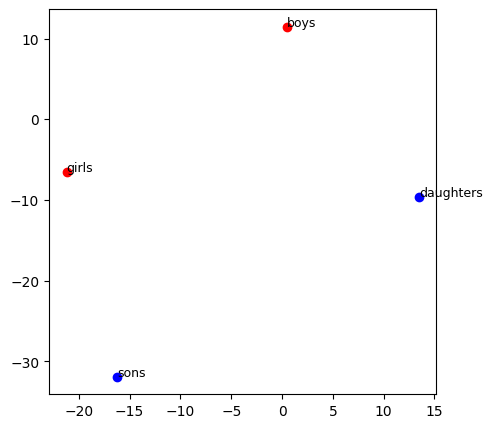

In [10]:
# plot the t-sne graph, labelling the data point with the words
plt.figure(figsize=(5, 5))
plt.scatter(V_trained_tsne_target_words[:, 0], V_trained_tsne_target_words[:, 1], color='blue')
plt.scatter(V_trained_tsne_similar_words[:, 0], V_trained_tsne_similar_words[:, 1], color='red')

# label the data points with its corresponding words slightly above each data point
for i, word in enumerate(target_words):
    x, y = V_trained_tsne_target_words[i]
    plt.text(x, y+0.1, word, fontsize=9)

    x, y = V_trained_tsne_similar_words[i]
    plt.text(x, y+0.1, similar_words[i], fontsize=9)

plt.show()

In [11]:
# use PCA to reduce the dimensionality of the embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
V_trained_pca = pca.fit_transform(best_V.T)

target_indices = [vocab_train[word] for word in target_words]
similar_indices = [vocab_train[word] for word in similar_words]


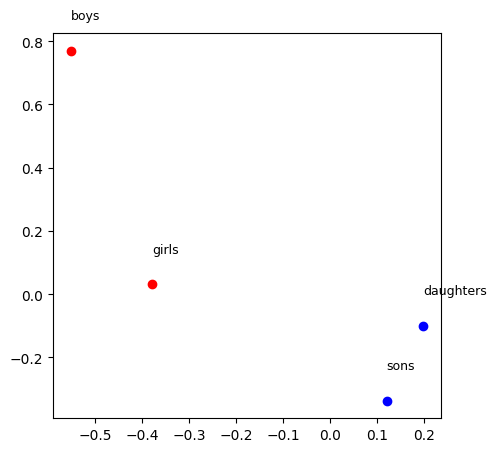

In [12]:
# plot the pca graph, labelling the data point with the words
plt.figure(figsize=(5, 5))
plt.scatter(V_trained_pca[target_indices, 0], V_trained_pca[target_indices, 1], color='blue')
plt.scatter(V_trained_pca[similar_indices, 0], V_trained_pca[similar_indices, 1], color='red')

# label the data points with its corresponding words slightly above each data point
for i, word in enumerate(target_words):
    x, y = V_trained_pca[target_indices[i]]
    plt.text(x, y+0.1, word, fontsize=9)

    x, y = V_trained_pca[similar_indices[i]]
    plt.text(x, y+0.1, similar_words[i], fontsize=9)